# Summarizing Emails using Machine Learning
## Table of Contents
1. Imports & Initalization <br>
2. Retrieve Preprocessed Data <br>
3. TextRank Modeling Word2vec<br>
    A. Prepare Model <br>
    B. BC3 Corpus Summary <br>
    C. BC3 Corpus ROUGE Evaluation <br>
    D. Enron Dataset Summary <br>
4. TextRank Modeling Bert<br>
5. BERTSum Modeling

This notebook uses two different methods for extractive summarizaiton. The first is the TextRank algorithim found at: https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/

TextRank uses sentence embeddings to determine sentence similarity to determine the most important sentences in a corpus. I used word embeddings from both [word2Vec](https://en.wikipedia.org/wiki/Word2vec) and from the embeddings determined by the [BERT deep learning model](https://github.com/UKPLab/sentence-transformers)

The second method uses the [Bert-Classifier.](https://github.com/jihun-hong/Bert-Classifier) Which is a fine-tuned version of the BERT model used for extractive text summarization. 

The algorithim will generate summaries of someone's inbox over a period of time. The BC3 Corpus contains human summaries that can be used to generate ROUGE metrics to better understand the accuracy of the summarizations. A general summary of TextRank is shown below. 

<img src="./images/TextRank_Workflow.jpg">

## Imports & Initalization

In [1]:
import pandas as pd
import numpy as np
import rouge
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter
from sentence_transformers import SentenceTransformer

## Retrieve Preprocessed Data

Load pickled dataframe produced by the [Process_Emails](https://github.com/dailykirt/ML_Enron_email_summary/blob/master/notebooks/Process_Emails.ipynb) notebook. 

In [2]:
#Load Data
ENRON_PICKLE_LOC = "../data/dataframes/wrangled_enron_full_df.pkl"
BC3_PICKLE_LOC  = "../data/dataframes/wrangled_BC3_df.pkl"

enron_df = pd.read_pickle(ENRON_PICKLE_LOC)
BC3_df = pd.read_pickle(BC3_PICKLE_LOC)

## TextRank Modeling

### Prepare Model

This ML algorithim uses the GloVe word embeddings generated by the pre-trained Wikipedia 2014 + Gigaword 5 mode. 

In [3]:
#These one time executions to download the model locally.  
#nltk.download('punkt')
#nltk.download('stopwords')
#! wget http://nlp.stanford.edu/data/glove.6B.zip
#! unzip glove*.zip

In [4]:
def extract_word_vectors():
    '''This returns word vectors from the pretrained glove model. '''
    word_embeddings = {}
    f = open('glove.6B.300d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()
    return word_embeddings

In [5]:
def get_extractive_sentences(df):
    '''Retrieve original email sentences and index them. This will be used to generate the extracted summaries. '''
    if (type(df.extractive_sentences) != list):
        sentences_list = df.extractive_sentences.tolist()
    else:
        sentences_list = df.extractive_sentences
    #flatten list as tuples containting (sentence, dataframe index)  to reassociate summary with original email. 
    sentences = []
    for counter, sublist in enumerate(sentences_list):
        for item in sublist:
            sentences.append([counter, item]) 
    return sentences

In [6]:
def get_tokenized_sentences(df):
    '''
    The tokenized sentences were done during preprocessing, 
    so this function retrieves them from the dataframe, then flattens the list. 
    '''
    if (type(df.extractive_sentences) != list):
        clean_sentences = df.tokenized_body.tolist()
    else:
        clean_sentences = df.tokenized_body
    #flatten list
    clean_sentences = [y for x in clean_sentences for y in x]
    return clean_sentences

In [7]:
def create_sentence_vectors(clean_sentences, word_embeddings):
    '''Create sentence_vectors for each tokenized sentence using the word_embeddings model. '''
    sentence_vectors = []
    for i in clean_sentences:
        if len(i) != 0:
            v = sum([word_embeddings.get(w, np.zeros((300,))) for w in i.split()])/(len(i.split())+0.001)
        else:
            v = np.zeros((300,))
        sentence_vectors.append(v)
    return sentence_vectors

In [8]:
def rank_sentences(sentences, sentence_vectors):
    '''This function takes in a list of sentences to input into TextRank. The resulting ranks are what the model 
    calculated as the most important sentences. '''
    sim_mat = np.zeros([len(sentences), len(sentences)])
    #Initialize matrix with cosine similarity scores. 
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                shape_len = len(sentence_vectors[i])
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,shape_len), sentence_vectors[j].reshape(1,shape_len))[0,0]
    nx_graph = nx.from_numpy_array(sim_mat)
    
    #Pair sentence with it's similarity score then sort.    
    try:
        scores = nx.pagerank(nx_graph)
        ranked_sentences = sorted(((scores[i],s[0],s[1]) for i,s in enumerate(sentences)), reverse=True)
    except:
        ranked_sentences = sorted(((0,s[0],s[1]) for i,s in enumerate(sentences)), reverse=True)

    return ranked_sentences

In [9]:
def summarize_emails(word_embeddings, masked_df):
    '''Function to wrap up summarization process'''
    if len(masked_df) != 1:
        print("Total number of emails to summarize: " + str(len(masked_df)))
    sentences = get_extractive_sentences(masked_df)
    clean_sentences = get_tokenized_sentences(masked_df)
    #Generate sentence vectors
    sentence_vectors = create_sentence_vectors(clean_sentences, word_embeddings)
    #Create a list of ranked sentences. 
    ranked_sentences = rank_sentences(sentences, sentence_vectors)
    return ranked_sentences

In [10]:
#color scheme to help distinguish summarizaiton text. 
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def display_summary(enron_masked_df, ranked_sentences):
  '''Specify number of sentences as a fraction of total emails. '''
  sn = (len(enron_masked_df) // 10) + 1

  # Generate summary
  for i in range(sn):
    #pull date and subject from original email
    email_date = str(enron_masked_df['date'].iloc[ranked_sentences[i][1]])
    email_subject = str(enron_masked_df['subject'].iloc[ranked_sentences[i][1]])
    email_from = str(enron_masked_df['from'].iloc[ranked_sentences[i][1]])
    print( bcolors.BOLD + "Date: "+ email_date  + 
          " Subject: " + email_subject +
          " From: " + email_from + bcolors.ENDC +
          "\nSummary: " + str(ranked_sentences[i][2]))

### BC3 Corpus Summary 

In [11]:
#Extract word vectors. This may take some time, but it only needs to be done once.
word_embeddings = extract_word_vectors()

In [13]:
#First look into what a single email summary looks like.
masked_df = BC3_df[(BC3_df['to'] == 'w3c-wai-ig@w3.org')][:1]
masked_df['body'].iloc[0]

"I need to help assemble and populate a small computer lab to examine web usability issues. This is a very large ballpark and I need to narrow the options we're going to explore. I'm seeking your opinion about what tools we should test with. We have to start someplace and picking a specific set of tools seems to be a reasonable place. I gather that there's no such thing as a perfect list but I need to put one together anyway. I'd like to hear about your opinions and preferences about tools if you care to share them. I suspect a public forum is not the best place to share these sentiments. Please respond privately so I don't get shot for starting another browser war."

In [14]:
#Take a look at a single ML summary. 
ranked_sentences = summarize_emails(word_embeddings, masked_df)
display_summary(masked_df, ranked_sentences)

Date: 1998-11-24 02:06:21+00:00 Subject: Usability testing From: Joe Night <joe.night@gateway2000.com>
Summary: We have to start someplace and picking a specific set of tools seems to be a reasonable place.


In [15]:
#Here are the full rankings for each sentence in the previous email. format is: (text rank, email index, summary)
ranked_sentences

[(0.13124809824783712,
  0,
  'We have to start someplace and picking a specific set of tools seems to be a reasonable place.'),
 (0.1312470511440184,
  0,
  "I gather that there's no such thing as a perfect list but I need to put one together anyway."),
 (0.1293467319082171,
  0,
  "I'd like to hear about your opinions and preferences about tools if you care to share them."),
 (0.12512489790598869,
  0,
  "Please respond privately so I don't get shot for starting another browser war."),
 (0.12473648307885793,
  0,
  "This is a very large ballpark and I need to narrow the options we're going to explore."),
 (0.12273061326319619,
  0,
  'I need to help assemble and populate a small computer lab to examine web usability issues.'),
 (0.1225641874869565,
  0,
  'I suspect a public forum is not the best place to share these sentiments.'),
 (0.113001936964928,
  0,
  "I'm seeking your opinion about what tools we should test with.")]

## BC3 Corpus ROUGE Evaluation

The rouge metric (https://pypi.org/project/py-rouge/) is an evaluation metric used to test machine generated summaries against a human "Gold standard". Using the same Text rank summarization methods used on the Enron dataset, the following evaluates the algorithim against the BC3 Corpus. This is one of the few email datasets that contain human summarizations. You can find an overview of top ROUGE scores by algorithim at the [Cornell Newsroom](https://summari.es/). Currently, the leading TextRank summary has a R-1 F-Score score of 24.45, while the leading algorithim 'Modified P-G' has a score of 39.91. 

In [16]:
evaluator = rouge.Rouge(metrics=['rouge-n'],
                           max_n=1,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=True)

#There are three different human summaries for the same email. 
listno = masked_df['listno'].iloc[0]
email_no = masked_df['email_num'].iloc[0]
masked_summaries = BC3_df[(BC3_df['listno'] == listno) & (BC3_df['email_num'] == email_no)]
masked_summaries.head()
full_body = masked_df['body'].iloc[0]
print("Full Email: " + full_body + '\n')

Full Email: I need to help assemble and populate a small computer lab to examine web usability issues. This is a very large ballpark and I need to narrow the options we're going to explore. I'm seeking your opinion about what tools we should test with. We have to start someplace and picking a specific set of tools seems to be a reasonable place. I gather that there's no such thing as a perfect list but I need to put one together anyway. I'd like to hear about your opinions and preferences about tools if you care to share them. I suspect a public forum is not the best place to share these sentiments. Please respond privately so I don't get shot for starting another browser war.



In [17]:
#A summary that is an exact copy of the 'gold standard' should give a score of 1.0 
reference = masked_summaries['summary'].iloc[0]
perfect_score = evaluator.get_scores(reference, reference)
print(perfect_score)

{'rouge-1': {'f': 1.0, 'p': 1.0, 'r': 1.0}}


We can now use the functions defined above to see what TextRank determines as the most important sentence in the email above. 

In [20]:
references = masked_summaries['summary'].tolist()
hypothesis = ranked_sentences[0][2]
print("ML Summary: " + hypothesis + "\n") 

ML Summary: We have to start someplace and picking a specific set of tools seems to be a reasonable place.



Each email may have more than once human summary. We can calculate the ROUGE score of each one. 

In [21]:
for reference in references:
    print("Human Summary: " + reference ) 
    scores = evaluator.get_scores(hypothesis, reference)
    print(str(scores) + "\n")

Human Summary: Joe says that he is helping to set-up a small computer lab to examine web usability issues and to narrow the options he is asking others' opinions on tools that should be tested.
{'rouge-1': {'f': 0.2692307692307692, 'p': 0.3888888888888889, 'r': 0.20588235294117646}}

Human Summary: Joe said he needed help assemble and populate a computer lab to examine web usability issues, since it's a large topic he wanted to narrow the options explored and hear people's opinion about the tools that should be used. He requested people to share their opinions and preferences privately.
{'rouge-1': {'f': 0.2028985507246377, 'p': 0.3888888888888889, 'r': 0.13725490196078433}}

Human Summary: A brain storming session requesting help with assembling and populating a small computer lab to examine usability issues. Private responses are preferred so as not to start a browser war
{'rouge-1': {'f': 0.25, 'p': 0.3333333333333333, 'r': 0.2}}



Since the summaries are extractive, there is most likely a best match sentence that will maximize the ROUGE score for each of the human summaries. 

In [22]:
top_summaries = []

for reference in references:
    top_score = 0.0
    for sentence in ranked_sentences:
        hypothesis = sentence[2]
        score = evaluator.get_scores(hypothesis, reference)['rouge-1']['f']
        if top_score < score:
            top_score = score
            top_summary = (hypothesis, reference, score)
    top_summaries.append(top_summary)

In [23]:
top_summaries

[('I need to help assemble and populate a small computer lab to examine web usability issues.',
  "Joe says that he is helping to set-up a small computer lab to examine web usability issues and to narrow the options he is asking others' opinions on tools that should be tested.",
  0.48),
 ('I need to help assemble and populate a small computer lab to examine web usability issues.',
  "Joe said he needed help assemble and populate a computer lab to examine web usability issues, since it's a large topic he wanted to narrow the options explored and hear people's opinion about the tools that should be used. He requested people to share their opinions and preferences privately.",
  0.4179104477611941),
 ('I need to help assemble and populate a small computer lab to examine web usability issues.',
  'A brain storming session requesting help with assembling and populating a small computer lab to examine usability issues. Private responses are preferred so as not to start a browser war',
  0.5

We see that one sentence in the email provides the top ROUGE score for each human summary. It also happens to be better than the one the TextRank algorithim has picked. Lets apply this to the whole dataset to get the maximum ROUGE score an extractive summarization approach could take.  

In [24]:
scores = []
for index, row in BC3_df.iterrows():
    reference = row['summary']
    hypotheses = row['extractive_sentences']
    top_score = (0.0,'','')
    for hypothesis in hypotheses:
        score = evaluator.get_scores(hypothesis, reference)['rouge-1']['f']
        if top_score[0] < score:
            top_score = (score, reference, hypothesis)
    scores.append(top_score)
scores[:10]

[(0.6071428571428571,
  'Jacob suggested to hold two week meetings, the first will discuss user service issues and all other issues the following week, he said people can attend one week or both.',
  'I suggest that future meetings are held for two weeks, with applications and user services issues the first week, and all other issues the second week.'),
 (0.3243243243243243,
  'Jacob suggests that future IETF meetings be spread over two weeks.',
  'I suggest that future meetings are held for two weeks, with applications and user services issues the first week, and all other issues the second week.'),
 (0.33962264150943394,
  'The topic is the logistics of scheduling IETF meetings A suggestion is made to hold future meetings for two weeks to spread out the volume of participants',
  'I suggest that future meetings are held for two weeks, with applications and user services issues the first week, and all other issues the second week.'),
 (0.33333333333333326,
  "Terry supported Jacob's i

Above we see more examples of the top scoring extracted sentences. We can visualize this to see the best possible scores an extractive summarization system can have. 

Number of human summaries 662
F1 average =  0.3452468016613802


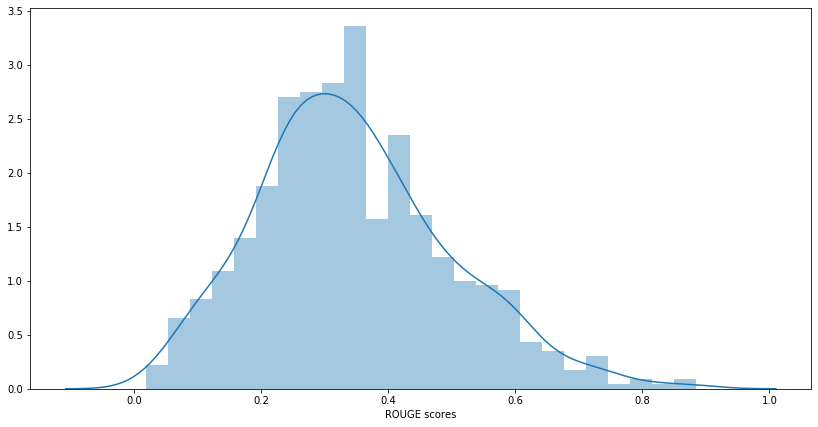

In [25]:
def plot_scores(scores):
    #removing 0 outliers since it meant page rank failed
    scores = [i for i in scores if i != 0.0]
    print("Number of human summaries " + str(len(scores)))
    print('F1 average =  ' + str(sum(scores) / len(scores)))

    _,ax = plt.subplots(figsize = (14,7))
    sns.distplot(scores, bins = 25)
    ax.set_xlabel('ROUGE scores')

unzipped = list(zip(*scores))
best_scores = unzipped[0]
plot_scores(best_scores)

It seems that even the best picked extractive sentences only get an average ROUGE score of 0.345. The low score is probably explained by the attempt to summarize the email in a single sentence, while the human summaries tend to be more flexible. ROUGE1 scores also simply measure word overlap of each unigram (single words). Human summaries are not limited to the same words in the email. While the ROUGE metric is not perfect in measuring the sucesss of a summarization algorithim, it is a good start. We can now measure how the TextRank algorithim stacks up against the best scores in this dataset. The first attempt will use TextRank on each individual email. 

In [26]:
def sum_single(df):
    scores = []
    for i in range(0, len(df.index)):  
        row = df.iloc[i:i+1, :]
        references = row.summary
        ranked_sentences = summarize_emails(word_embeddings, row)
        hypothesis = ranked_sentences[0][2]
        scores.append(evaluator.get_scores(hypothesis, reference)['rouge-1']['f'])
    return scores

Number of human summaries 46
F1 average =  0.09261185198959114


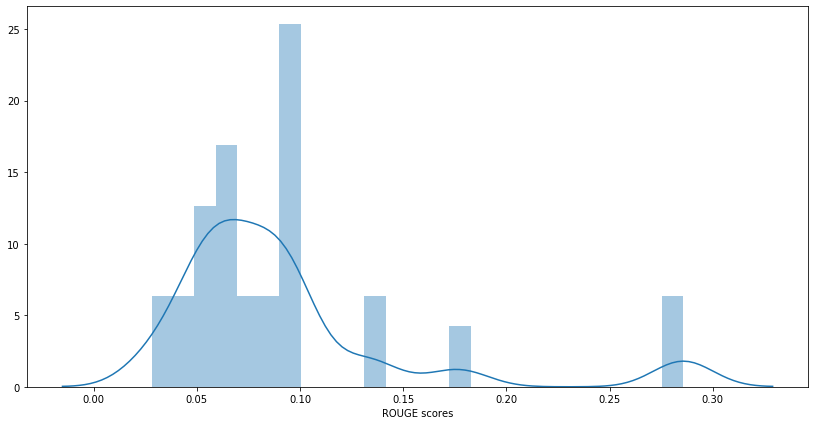

In [31]:
#Take a look at a single inbox. Number of summaries will differ from full inbox, since pagerank fails to converge on certain emails. 
masked_df = BC3_df[BC3_df['to'] == 'w3c-wai-ig@w3.org']
scores = sum_single(masked_df)
plot_scores(scores)

Number of human summaries 528
F1 average =  0.09417194742192002


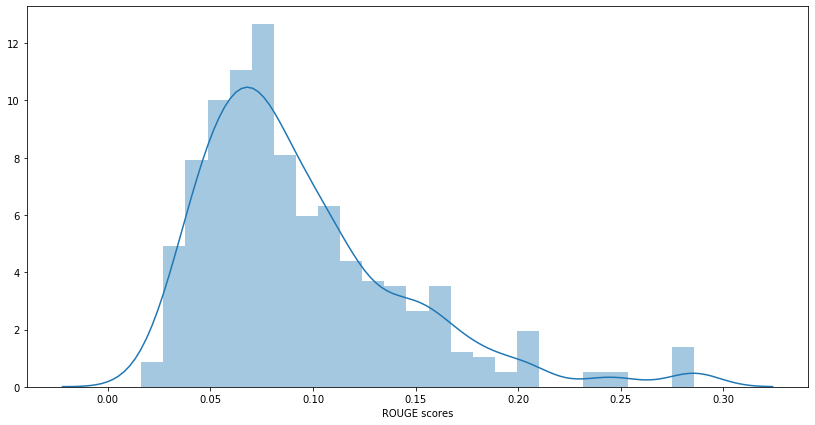

In [27]:
scores = sum_single(BC3_df)
plot_scores(scores)

If we only give a single email as an input to each TextRank summary, the result is far below the best score of 0.34. If we rank more sentences at a time TextRank might generate a better context of the inbox it is trying to summarize and it's performance may improve. The idea would be to rank every sentence in an inbox, but then pull only the rankings for a single email to determine the top sentence in an email.  

Total number of emails to summarize: 24
Number of human summaries 51
F1 average =  0.2375112191092578


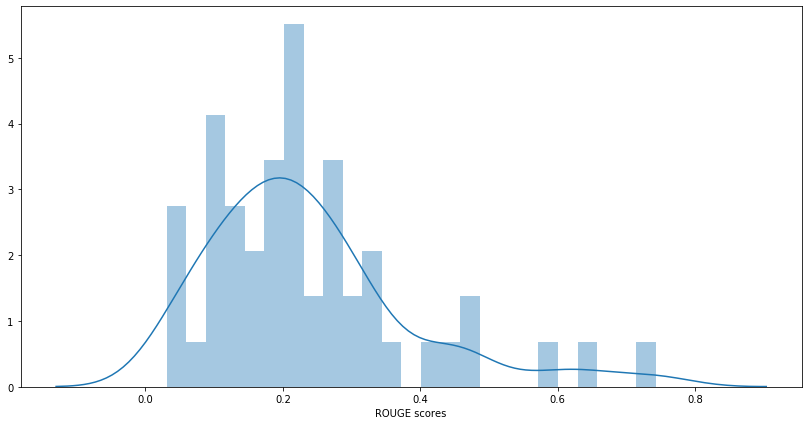

In [30]:
#compare best ML summary with each human summary
def sum_full(df, ranked_sentences):
    scores = []
    for i in range(0, len(df)):
        email_sentences = [item for item in ranked_sentences if i in item]
        hypothesis = max(email_sentences, key=itemgetter(0))
        listno = masked_df['listno'].iloc[i]
        email_num = masked_df['email_num'].iloc[i]
        h_summaries = BC3_df[(BC3_df['listno'] == listno) & (BC3_df['email_num'] == email_num)]['summary']
        for reference in h_summaries:
            scores.append(evaluator.get_scores(hypothesis[2], reference)['rouge-1']['f'])
    return scores

#Try to apply textrank on a full inbox to see if summarization improves with more emails. 
masked_df = masked_df.drop_duplicates(subset='body', keep='first')
ranked_sentences = summarize_emails(word_embeddings, masked_df)
scores = sum_full(masked_df, ranked_sentences)
plot_scores(scores)

We can see around  2x improvement for giving the algorithim the full inbox, rather than trying to summarize each individual email. We can also try model on full dataset, regardless of person. The following execution will take some time.

Total number of emails to summarize: 259
Number of human summaries 604
F1 average =  0.22599398085168812


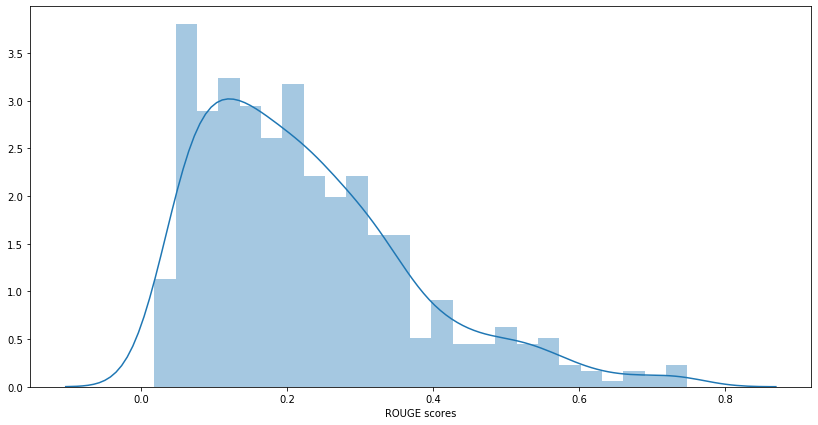

In [32]:
masked_df = BC3_df.drop_duplicates(subset='body', keep='first')
ranked_sentences = summarize_emails(word_embeddings, masked_df)
scores = sum_full(masked_df, ranked_sentences)
plot_scores(scores)

Overall TextRank improves as more text is given to it. The tradeoff however is that the algorithim goes in quadradic time. Each sentence must compare itself to each other sentence to generate it's ranking. 

## Enron Dataset Summary 

We can now apply the model to the Enron dataset. While we won't be able to measure the performance, we know that summarizing inboxes should still work reasonably well. 

In [33]:
def subset_emails(df, start_date, end_date, person):  
    '''Outputs a subset of the enron dataset masked by the person and a timeframe. '''
    summarization_mask = (enron_df['date'] >= start_date) & (enron_df['date'] <= end_date) & (enron_df['employee'] == person)
    enron_masked_df = df.loc[summarization_mask]
    return enron_masked_df   

Jeffrey skilling was the CEO of Enron during the scandal. He would probably have a higher volume of emails during a two week period than most other employees. 

In [34]:
#Define emails to be summarized. 
start_date = '2001-10-01 00:00:00'
end_date = '2001-10-14 23:59:59'
person = 'skilling-j'
masked_df = subset_emails(enron_df, start_date, end_date, person)
ranked_sentences = summarize_emails(word_embeddings, masked_df)

Total number of emails to summarize: 72


In [35]:
display_summary(masked_df, ranked_sentences)

Date: 2001-10-08 08:36:38+00:00 Subject: Update - Basel Conference New York From: news@ibcuk.co.uk
Summary: However, as the business community appears to be trying to get back to normal as far as possible, we have decided that the conference should proceed as planned.
Date: 2001-10-02 19:04:24+00:00 Subject: Jeffrey Skilling, your October E-lert is now available From: mccann@nc.rr.com
Summary: A complete story on the origin of Halloween will be on the Business Cafe Web site October 2531 at http://www.BusinessCafeOnline.com Your October 2001 issue of Elert for personal development in business is now available on http://www.BusinessCafeOnline.com Included in the October 2001 issue are these three articles: Flying Off Over Office Politics What Men Can Learn
Date: 2001-10-04 03:13:05+00:00 Subject: h: Eyeforenergy Briefing From: bruno@eyeforenergy.com
Summary: EDITORIAL A Focus on the latest developments in Europe ARTICLES European Utility Sector: Survival of the Fittest Through Mergers & 

The model picked sentences that talk about a conference in new york that will continue despite the 9/11 atttacks. The other sentences seem to be picked from a newsletter. Since newsletters have a high volume of text, there would be a higher chance a sentence might be picked from it. 

In [36]:
#Examples of a full email. 
masked_df['body'].iloc[ranked_sentences[0][1]]

"Dear Mr Skilling, http://www.ibcfinancial.com/bm1272/?source=bm1272em2 Update on IBC's major international conference: BASEL MEETING THE PRACTICAL CHALLENGES 31st October and 1st November 2001 New York We have obviously considered very carefully whether to continue with this event in the light of the recent terrible events in New York. However, as the business community appears to be trying to get back to normal as far as possible, we have decided that the conference should proceed as planned. We therefore hope you will take this excellent opportunity to hear the industry response to the latest Basel proposals on Capital Adequacy and Risk Management, and to gain practical advice on meeting the significant business challenges that these proposals pose to the management of risk within the financial services industry. Conference highlights include: A keynote address from William Rutledge, Executive Vice President, FEDERAL RESERVE BANK OF NEW YORK An impressive panel of leading industry s

Kenneth Lay was the CEO prior to Jeffery Skilling. 

In [55]:
#Summarization from another inbox
start_date = '2001-10-01 00:00:00'
end_date = '2001-10-14 23:59:59'
person = 'lay-k'
masked_df = subset_emails(enron_df, start_date, end_date, person)
ranked_sentences = summarize_emails(word_embeddings, masked_df)
display_summary(masked_df, ranked_sentences)

Total number of emails to summarize: 90
Date: 2001-10-11 19:39:41+00:00 Subject: FYI From: bonnie.allen@enron.com
Summary: I know that probably someone has already sent in an email with this comment, especially during the time you requested the employees let you know how we could all pull together to improve the outlook that the outside world has on Enron.
Date: 2001-10-11 19:41:45+00:00 Subject: RV: Lay It On the Line Survey Results From: roberto.volonte@enron.com
Summary: Work environment: pay and benefits true meritocracy X unlimited opportunities The results of our survey confirmed for the Management Committee and me the great things you feel about Enron and also what you see as the issues we must address to move Enron forward.
Date: 2001-10-04 10:26:53+00:00 Subject: Note from Nihon Keizai Shimbun From: john.sherriff@enron.com
Summary: Mike is the key guy to determine if your time would be well spent from his business perspective but relative to my businesses, I doubt if it would 

In [56]:
#Examples of a full email. 
masked_df['body'].iloc[ranked_sentences[0][1]]

"I apologize for this email being so late. I know that probably someone has already sent in an email with this comment, especially during the time you requested the employees let you know how we could all pull together to improve the outlook that the outside world has on Enron. I had a gentleman on our floor a few weeks back, that told me he had worked for Enron a while back, he said the most damaging thing that hurts Enron in the public eye, is the fact that a person can seldom talk to the same person in a department more than a few times before their contact in that department moves to another department or leaves. He said it gives the public a feeling of insecurity in trusting a company where the employees move around so much. I hope this doesn't upset you, I just thought I would let you know what one gentlemen told me regarding the company. I absolutely love the foundation that you have built Enron on, and I only hope that more company's follow suit. Have a wonderful day."

This last example is to show how TextRank works with a high volume of very short emails. 

In [39]:
#One more example
start_date = '2001-10-01 00:00:00'
end_date = '2001-10-14 23:59:59'
person = 'lenhart-m'
masked_df = subset_emails(enron_df, start_date, end_date, person)
ranked_sentences = summarize_emails(word_embeddings, masked_df)
display_summary(masked_df, ranked_sentences)

Total number of emails to summarize: 121
Date: 2001-10-03 20:00:52+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: i think i might need to pay up to get a house
Date: 2001-10-05 14:51:13+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: i can think of a few things
Date: 2001-10-05 15:30:00+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: i will let you know later.
Date: 2001-10-09 19:26:43+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: this is a photo of the girl i think you look like but it isn't really a good pic.
Date: 2001-10-04 16:24:25+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: i think i need to pay more than i want to.
Date: 2001-10-10 17:10:04+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: i dont think you look like her anymore.
Date: 2001-10-10 17:01:34+00:00 Subject: RE: From: matthew.lenhart@enron.com
Summary: let me know what she says.
Date: 2001-10-09 20:32:30+00:00 Subject: RE: From: matthew.lenha

In [40]:
#Examples of a full email. 
masked_df['body'].iloc[ranked_sentences[0][1]]

'lets bet your dinner on it right now. i think i might need to pay up to get a house'

# TextRank Modeling: (BERT)

BERT, which stands for 'Bidirectional Encoder Representations from Transformers', is a state of the art NLP model developed by Google. In the previous section, we used word2vec to generate the sentence vectors for the TextRank summarization algorithm. word2vec is context free, meaning that for each word in the english language, there is only one word embedding associated with that. This means that word2vec may have difficulties distinguishing between "Going to get a new car" vs "Going to New York". BERT however, is able to pick up on the deeper contexts of sentences due to it's "deeply bidirectional" nature. This means that BERT picks up on the information on the left and right of each word token. 

We can use BERT to generate new sentence vector representaitons of our emails and see if the sentence ranking improves through the ROUGE metric. The following code will go over how you can leverage a pre-trained BERT model using the https://pypi.org/project/bert-embedding/ library. In this way, instead of building and do fine-tuning for an end-to-end NLP model, we can take advantage of the pre-trained model to generate our new word vectors. 

In [41]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import models, losses
from sentence_transformers import SentencesDataset, LoggingHandler, SentenceTransformer
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import *
import logging
from datetime import datetime

Since BERT takes into account word order there can be multipule embeddings of the same word. The idea of using the pre-trained model below, is to take the average of those many meanings a particular word can have. 

In [42]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

Now we can swap the word embeddings and measure if BERT works out better for this dataset. 

In [43]:
def create_sentence_vectors_bert(clean_sentences):
    sentence_vectors = []
    for i in clean_sentences:
        if len(i) != 0:
            v = np.average(model.encode(i), axis=0)
        else:
            v = np.zeros((768,))
        sentence_vectors.append(v)
    return sentence_vectors

In [44]:
def summarize_emails_bert(masked_df):
    if len(masked_df) != 1:
        print("Total number of emails to summarize: " + str(len(masked_df)))
    sentences = get_extractive_sentences(masked_df)
    clean_sentences = get_tokenized_sentences(masked_df)
    #Generate sentence vectors
    sentence_vectors = create_sentence_vectors_bert(clean_sentences)
    #Create a list of ranked sentences. 
    ranked_sentences = rank_sentences(sentences, sentence_vectors)
    return ranked_sentences

In [45]:
def sum_single_bert(df):
    scores = []
    for i in range(0, len(df.index)):  
        row = df.iloc[i:i+1, :]
        references = row.summary
        ranked_sentences = summarize_emails_bert(row)
        hypothesis = ranked_sentences[0][2]
        scores.append(evaluator.get_scores(hypothesis, reference)['rouge-1']['f'])
    return scores

When applied to a single email we can see that BERT takes quite a bit longer to generate the embeddings. 

In [46]:
masked_df = BC3_df[(BC3_df['to'] == 'w3c-wai-ig@w3.org')][:1]
masked_df['body'].iloc[0]
ranked_sentences = summarize_emails_bert(masked_df)
display_summary(masked_df, ranked_sentences)

Date: 1998-11-24 02:06:21+00:00 Subject: Usability testing From: Joe Night <joe.night@gateway2000.com>
Summary: We have to start someplace and picking a specific set of tools seems to be a reasonable place.


The top sentence generated by BERT is the same as word2vec, however the rest of the rankings diverge quite a bit. We can see if BERT has improved by plotting the ROUGE scores throughout the whole dataset again. 

Number of human summaries 479
F1 average =  0.08346175337073987


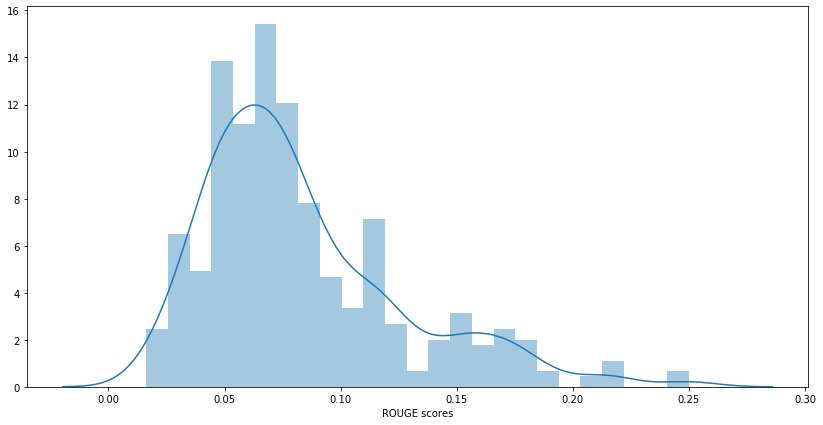

In [47]:
scores = sum_single_bert(BC3_df)
plot_scores(scores)

Total number of emails to summarize: 259
Number of human summaries 617
F1 average =  0.19825837893628018


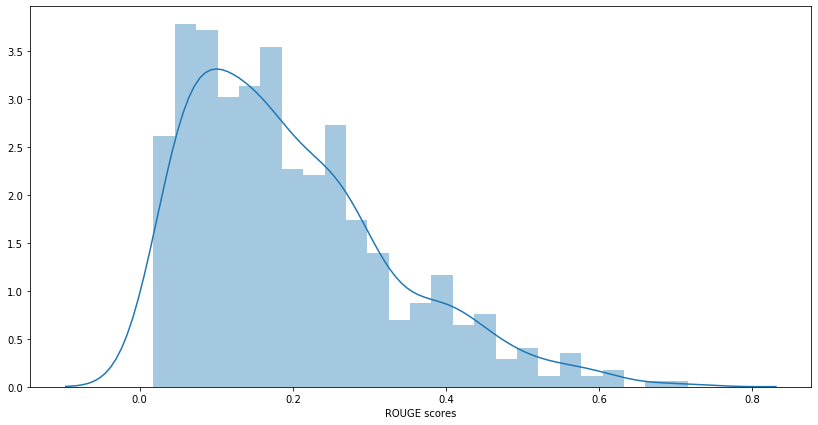

In [48]:
#compare best ML summary with each human summary
def sum_full(df, ranked_sentences):
    scores = []
    for i in range(0, len(df)):
        email_sentences = [item for item in ranked_sentences if i in item]
        hypothesis = max(email_sentences, key=itemgetter(0))
        listno = masked_df['listno'].iloc[i]
        email_num = masked_df['email_num'].iloc[i]
        h_summaries = BC3_df[(BC3_df['listno'] == listno) & (BC3_df['email_num'] == email_num)]['summary']
        for reference in h_summaries:
            scores.append(evaluator.get_scores(hypothesis[2], reference)['rouge-1']['f'])
    return scores

#Try to apply textrank on a full inbox to see if summarization improves with more emails. 
masked_df = BC3_df.drop_duplicates(subset='body', keep='first')
ranked_sentences = summarize_emails_bert(masked_df)
scores = sum_full(masked_df, ranked_sentences)
plot_scores(scores)

Surprisingly the BERT word embeddings had a slightly worse performance than word2vec. This may be because we should be approaching the text pre-processing differently. 

# BERTSum Modeling

The following code is based off of https://github.com/jihun-hong/Bert-Classifier

'BertSum' is a version of BERT that is specifically trained for extractive summarization. Similar to how we found the best ROUGE-1 score using a greedy algorithim to compare each email sentence to the human summary, this model used the same method to generate a training dataset for the neural network to predict the highest ROUGE-2 score. The dataset they used was based on news summarization datasets.

Its possible to use BERT and train it on the BC3 dataset. The fastest way to try out this new model though would be  to download the repository, make a few edits to the source code so we can input email text in then make a prediction. 

In [49]:
#Import the code as a custom module. 
import sys
sys.path.insert(0, '/home/kirt/Documents/ML_Enron_email_summary/notebooks/Bert-Classifier/src/')
import inference

In [58]:
#First look into what a single email summary looks like.
masked_df = BC3_df[(BC3_df['to'] == 'w3c-wai-ig@w3.org')][:1]
text = masked_df['body'].iloc[0]

hypothesis = inference.summarize_text(text,1)
print(hypothesis)

references = masked_df['summary'].tolist()
for reference in references:
    print("Human Summary: " + reference ) 
    scores = evaluator.get_scores(hypothesis, reference)
    print(str(scores) + "\n")

I 'm seeking your opinion about what tools we should test with.
Human Summary: Joe says that he is helping to set-up a small computer lab to examine web usability issues and to narrow the options he is asking others' opinions on tools that should be tested.
{'rouge-1': {'f': 0.1739130434782609, 'p': 0.3333333333333333, 'r': 0.11764705882352941}}



Much like before, we can make predictions on each email. Using this model on emails takes the longest out of the summarization methods we have used so far. There also seems to be a maximum amount of tokens (510) this can handle, which makes it difficult to try to summarize more than one email at a time. 

In [ ]:
scores = []
for index, row in BC3_df.iterrows():
    reference = row.summary
    hypothesis = inference.summarize_text(row.body, 1)
    try:
        score = evaluator.get_scores(hypothesis, reference)['rouge-1']['f']
    except:
        score = 0.0
    scores.append((score, reference, hypothesis))

In [57]:
print(scores[:10])

[(0.6071428571428571, 'Jacob suggested to hold two week meetings, the first will discuss user service issues and all other issues the following week, he said people can attend one week or both.', 'I suggest that future meetings are held for two weeks, with applications and user services issues the first week, and all other issues the second week.'), (0.3243243243243243, 'Jacob suggests that future IETF meetings be spread over two weeks.', 'I suggest that future meetings are held for two weeks, with applications and user services issues the first week, and all other issues the second week.'), (0.33962264150943394, 'The topic is the logistics of scheduling IETF meetings A suggestion is made to hold future meetings for two weeks to spread out the volume of participants', 'I suggest that future meetings are held for two weeks, with applications and user services issues the first week, and all other issues the second week.'), (0.08695652173913043, "Terry supported Jacob's idea and suggested

Number of human summaries 594
F1 average =  0.24252652776411007


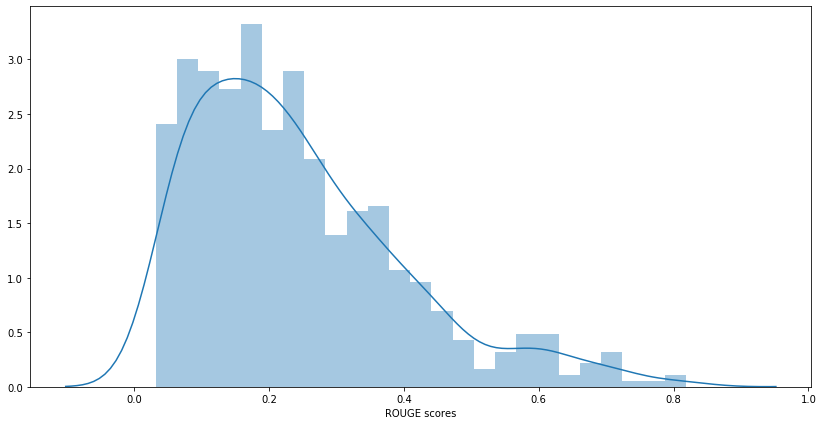

In [54]:
unzipped = list(zip(*scores))
best_scores = unzipped[0]
plot_scores(best_scores)

This model is slightly better than the TextRank model. 